# Notebook to compute risk (probability of occurence) and uncertainty (std). 

### Risk= the probability of occurence (model trained on all data)
### Uncertainty = stdv of three models trained with different seeds


# Import packages

In [94]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import GroupKFold

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.ensemble import RandomForestClassifier

from tqdm import tqdm

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [89]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
import matplotlib.cbook as cbook
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# from matplotlib_scalebar.scalebar import ScaleBar
# import great_circle_calculator.great_circle_calculator as gcc
import contextily as ctx

In [74]:
import os
import cartopy.crs as ccrs
import cartopy as ctpy
from math import floor
import matplotlib.pyplot as plt
from matplotlib import patheffects

import matplotlib
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
if os.name == 'nt':
    matplotlib.rc('font', family='Arial')
else:  # might need tweaking, must support black triangle for N arrow
    matplotlib.rc('font', family='DejaVu Sans')


def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.5, 0.05), linewidth=3,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2, fontsize= 16)
    left = x0+(x1-x0)*0.05
    # Add north arrow
    x, y, arrow_length = 0.05, 0.95, 0.1
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
#     # Plot the N arrow
#     t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
#         horizontalalignment='right', verticalalignment='bottom',
#         path_effects=buffer, zorder=2, fontsize= 18)
#     # Plot the scalebar without buffer, in case covered by text buffer
#     ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
#         linewidth=linewidth, zorder=3)

In [57]:
# import data
df = pd.read_csv(r"D:\phd\Chapter_2\nat_drivers\3exports\merged_31082021_catboost.csv")
df = df.dropna(subset=['pxid'])

In [58]:
FLC = ['contiguous (indigenous) forest',
 'contiguous low forest & thicket',
 'dense forest & woodland',
 'open woodland',
 'contiguous & dense plantation forest',
 'open & sparse plantation forest',
 'temporary unplanted (clear-felled) plantation forest',
 'low shrubland (other)',
 'low shrubland (fynbos)',
 'low shrubland (succulent karoo)',
 'low shrubland (nama karoo)',
 'sparsely wooded grassland',
 'natural grassland',
 'natural rivers',
 'natural estuaries & lagoons',
 'natural ocean & coastal',
 'natural lakes',
 'natural pans (flooded @ observation times)',
 'artificial dams (including canals)',
 'artificial sewage ponds',
 'artificial flooded mine pits',
 'herbaceous wetlands (currently mapped)',
 'herbaceous wetlands (previously mapped)',
 'mangrove wetlands',
 'natural rock surfaces',
 'dry pans',
 'eroded lands',
 'sand dunes (terrestrial)',
 'coastal sand & dunes',
 'bare riverbed material',
 'other bare',
 'cultivated commercial permanent orchards',
 'cultivated commercial permanent vines',
 'cultivated commercial sugarcane pivot irrigated',
 'cultivated commercial permanent pineapples',
 'cultivated commercial sugarcane non-pivot',
 'cultivated emerging farmer sugarcane non-pivot',
 'commercial annual crops pivot irrigated',
 'commercial annual crops non-pivot irrigated',
 'commercial annual crops rain-fed / dryland',
 'subsistence / small-scale annual crops',
 'fallow land & old fields (trees)',
 'fallow land & old fields (bush)',
 'fallow land & old fields (grass)',
 'fallow land & old fields (bare)',
 'fallow land & old fields (low shrub)',
 'residential formal (tree)',
 'residential formal (bush)',
 'residential formal (low veg / grass)',
 'residential formal (bare)',
 'residential informal (tree)',
 'residential informal (bush)',
 'residential informal (low veg / grass)',
 'residential informal (bare)',
 'village scattered (bare & low veg/ grss combo)',
 'village dense (bare & low veg / grss combo)',
 'smallholdings (tree)',
 'smallholdings (bush)',
 'smallholdings (low veg / grass)',
 'smallholdings (bare)',
 'urban recreational fields (tree)',
 'urban recreational fields (bush)',
 'urban recreational fields (grass)',
 'urban recreational fields (bare)',
 'commercial',
 'industrial',
 'roads & rails (major linear)',
 'mines: surface infrastructure',
 'mines: extraction pits, quarries',
 'mines: salt mines',
 'mine: tailings and resource dumps',
 'land-fills',
 'fallow land & old fields (wetlands)']

irrelevant = ['Unnamed: 0', 'system:index','ORIG_FID','gridcode', 'nx','ny','matches','moss-coverfraction']
redundant = ['bedrock_depth', 'carbon_organic', 'carbon_total', 'bulk_density', 'distance_to_coast', 'ph', 'warea', 'texture_class', 'silt_content']

df = df.drop([*irrelevant, *redundant], axis=1)

rep0 = ['flood','wSeasonality', 'aq_veg_area', 'rwi']
df[rep0+FLC] = df[rep0+FLC].fillna(0)
df = df.dropna()

# 82 features
top_fts = ['CHILI', 'Global_Human_Modification', 'SPI', 'bare-coverfraction',
       'cation_ex_capacity', 'clay_content', 'commercial',
       'commercial annual crops rain-fed / dryland',
       'contiguous & dense plantation forest',
       'contiguous (indigenous) forest', 'crops-coverfraction',
       'cultivated commercial permanent pineapples',
       'cultivated commercial sugarcane non-pivot', 'dense forest & woodland',
       'distance_to_roads', 'dsrcnt', 'fcc', 'flood', 'grass-coverfraction',
       'herbaceous wetlands (previously mapped)', 'industrial',
       'low shrubland (fynbos)', 'low shrubland (nama karoo)',
       'mangrove wetlands', 'minT', 'mines: surface infrastructure',
       'natural rock surfaces', 'nitrogen_total',
       'open & sparse plantation forest', 'precipitation',
       'roads & rails (major linear)', 'runoff', 'sand_content',
       'shrub-coverfraction', 'soc_100-200cm_mean',
       'sparsely wooded grassland', 'stone_content',
       'subsistence / small-scale annual crops',
       'temporary unplanted (clear-felled) plantation forest', 'topD',
       'tree-coverfraction', 'urban-coverfraction', 'wSeasonality',
       'water-permanent-coverfraction', 'water-seasonal-coverfraction',
       'wind_speed', 'contiguous low forest & thicket',
       'cultivated commercial permanent orchards',
       'cultivated commercial permanent vines',
       'low shrubland (succulent karoo)', 'natural estuaries & lagoons',
       'natural grassland', 'natural rivers', 'land-fills',
       'mine: tailings and resource dumps', 'mines: extraction pits, quarries',
       'mines: salt mines', 'natural lakes', 'natural ocean & coastal',
       'natural pans (flooded @ observation times)',
       'commercial annual crops pivot irrigated',
       'cultivated emerging farmer sugarcane non-pivot',
       'fallow land & old fields (bush)', 'fallow land & old fields (trees)',
       'residential formal (bare)', 'residential formal (bush)',
       'residential formal (low veg / grass)', 'residential informal (tree)',
       'urban recreational fields (bush)', 'urban recreational fields (tree)',
       'village scattered (bare & low veg/ grss combo)', 'aq_veg_area',
       'smallholdings (low veg / grass)', 'residential informal (bush)',
       'open woodland', 'cultivated commercial sugarcane pivot irrigated',
       'coastal sand & dunes', 'sand dunes (terrestrial)',
       'artificial dams (including canals)', 'artificial flooded mine pits',
       'artificial sewage ponds', 'low shrubland (other)']

df = df[[*top_fts, 'label', 'pxid', '.geo']]

df.reset_index(inplace=True, drop=True)

In [45]:
X = df[top_fts]
y = df[['label']]
columns = list(X)

In [46]:
# Get hyperparameters
params = {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 542, 'bootstrap': False}

In [96]:
%%time
#This cell takes a while in the order of 10 mins on a 8th gen i7

groups = df['pxid'].values
group_kfold = GroupKFold(n_splits=10)

# train + run inference (5 models)
inferences = []
list_test_sets = []
for i in tqdm(range(0,5)):
    seed = np.random.randint(0,1e6)
    clf = RandomForestClassifier(**params, random_state=seed, n_jobs = -1)
    for train_index, test_index in group_kfold.split(X, y, groups=groups):
        print('Splitting train-test data')
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        X_train = pd.DataFrame(X_train,columns=columns)
        X_test = pd.DataFrame(X_test,columns=columns)

        #training model
        print('Fitting model')
        clf.fit(X_train, y_train.values.ravel())
        inference = clf.predict_proba(X_test)
        inferences.append(inference[:,1])
        list_test_sets.append(test_index)

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model


 20%|████████████████▌                                                                  | 1/5 [08:26<33:46, 506.68s/it]

Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model


 40%|█████████████████████████████████▏                                                 | 2/5 [15:57<23:41, 473.76s/it]

Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model


 60%|█████████████████████████████████████████████████▊                                 | 3/5 [23:26<15:24, 462.40s/it]

Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model


 80%|██████████████████████████████████████████████████████████████████▍                | 4/5 [30:52<07:35, 455.91s/it]

Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model
Splitting train-test data
Fitting model


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [38:24<00:00, 460.89s/it]

Wall time: 38min 24s


In [97]:
#combining results from all iterations
test_set = list_test_sets[0]
inference_values = np.array(inferences[0])

for i in range(1,len(list_test_sets)):
    test_set = np.concatenate((test_set,list_test_sets[i]),axis=0)
    inference_values = np.concatenate((inference_values,np.array(inferences[i])),axis=0)

In [110]:
#bringing back variable names
X_test = pd.DataFrame(df.iloc[test_set],columns=columns)

In [116]:
probs= pd.DataFrame([test_set,inference_values]).T

ValueError: 2 columns passed, passed data had 1055430 columns

In [117]:
probs.columns = ['index','prob']
probs.head()

,index,prob
0,1.0,0.208487
1,2.0,0.199262
2,3.0,0.132841
3,5.0,0.182657
4,6.0,0.130996


In [122]:
prob_output = probs.groupby('index').agg({'prob':['mean', 'std']}).xs('prob', axis=1, drop_level=True).reset_index('index')

In [125]:
prob_output['pxid'] = df.iloc[prob_output.index]['pxid']

In [126]:
prob_output

,index,mean,std,pxid
0,0.0,0.781550,0.013085,347088.0
1,1.0,0.225461,0.013202,663826.0
2,2.0,0.220664,0.016169,663826.0
3,3.0,0.160148,0.018879,511659.0
4,4.0,0.309225,0.012689,108037.0
...,...,...,...,...
211081,211081.0,0.497786,0.024664,71329.0
211082,211082.0,0.504797,0.026628,71329.0
211083,211083.0,0.518819,0.035162,71329.0
211084,211084.0,0.067159,0.009728,505902.0


(array([155396.,  14914.,   9399.,   7114.,   5557.,   4345.,   3811.,
          3430.,   3622.,   3498.]),
 array([-3.68652176e-04,  9.96313127e-02,  1.99631278e-01,  2.99631242e-01,
         3.99631207e-01,  4.99631172e-01,  5.99631137e-01,  6.99631102e-01,
         7.99631067e-01,  8.99631031e-01,  9.99630996e-01]),
 <BarContainer object of 10 artists>)

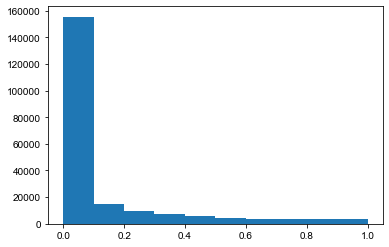

In [129]:
plt.hist(np.array(prob_output['mean']))

In [137]:
# Create map-aggregate by 5km blocks 
# Load grid
grid= gpd.read_file(r"D:\phd\Chapter_2\nat_drivers\3exports\grid5km.shp")
grid.columns = ['first', 'pxid', 'geometry']
                    
# Group by pxid
var = prob_output.groupby(["pxid"])["mean","std"].mean().reset_index()

merge = gpd.GeoDataFrame(pd.merge(var, grid, on=["pxid"]), crs={'init': 'epsg:4326'})

C:\Users\G10\AppData\Local\Temp/ipykernel_9736/753836737.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  var = prob_output.groupby(["pxid"])["mean","std"].mean().reset_index()
D:\ProgramData\envs\main\lib\site-packages\pyproj\crs\crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\G10\AppData\Local\Temp/ipykernel_9736/753836737.py:9: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  merge = gpd.G

In [138]:
var

,pxid,mean,std
0,20.0,6.826649e-03,3.285708e-03
1,21.0,4.018729e-07,9.657336e-08
2,37.0,5.036900e-02,8.484370e-03
3,92.0,2.422509e-01,2.170352e-02
4,93.0,4.565509e-07,2.135642e-07
...,...,...,...
35787,999847.0,7.385980e-04,1.010540e-03
35788,999919.0,3.694086e-04,8.251148e-04
35789,999936.0,2.263223e-01,1.224602e-02
35790,999956.0,5.654206e-07,1.422043e-07


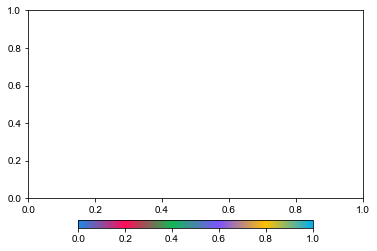

In [139]:
colors = ["#1E88E5", "#ff0d57", "#13B755", "#7C52FF", "#FFC000", "#00AEEF"] # 
cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    # Create colorbar legend
sm = plt.cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=0, vmax=1))
    # empty array for the data range
sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
plt.colorbar(sm, orientation = "horizontal", fraction=0.036, pad=0.1, aspect = 30)
plt.show()

D:\ProgramData\envs\main\lib\site-packages\cartopy\mpl\geoaxes.py:845: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS84 el ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
D:\ProgramData\envs\main\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
D:\ProgramData\envs\main\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use th

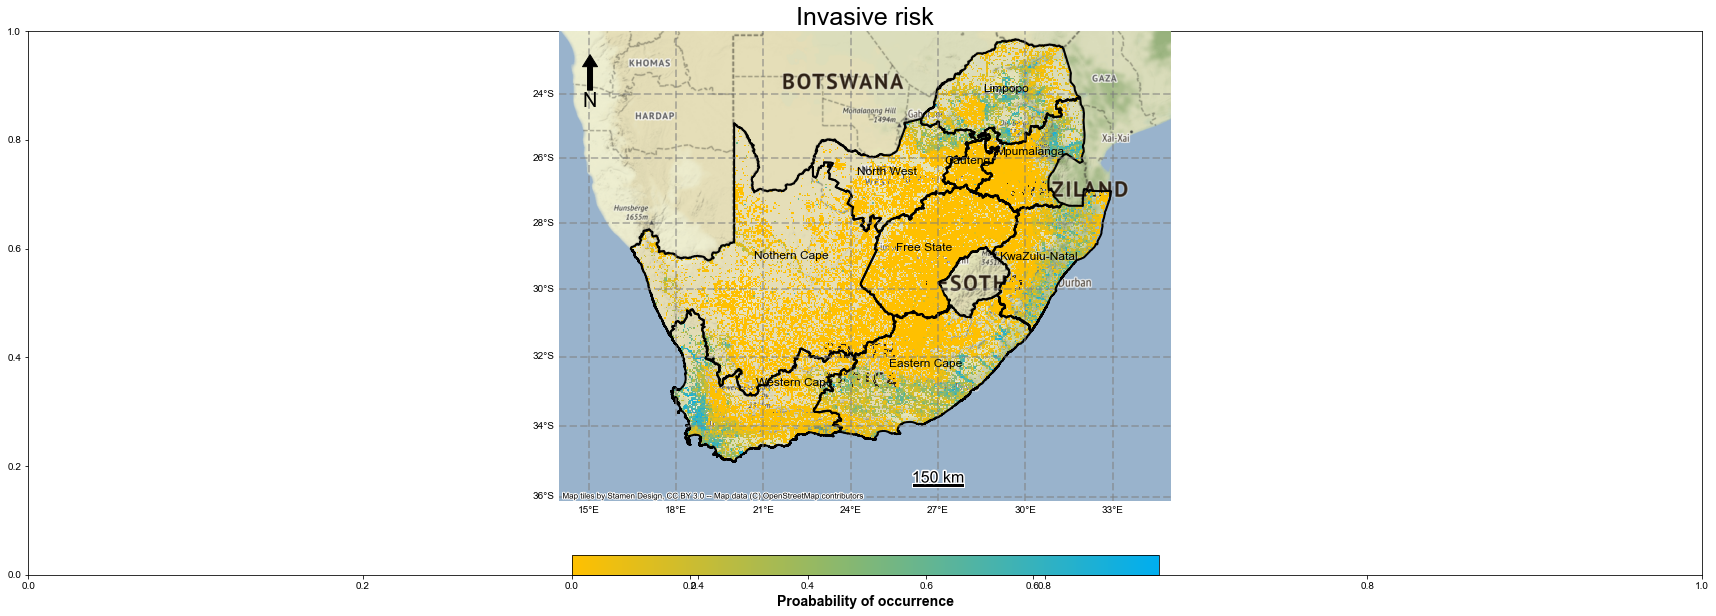

In [142]:
if __name__ == '__main__':
    
    #Set the Map Title
    title = 'Invasive risk'
    #Set the Colour bar title
    cb_label = 'Proabability of occurrence'
    colors = ["#FFC000", "#00AEEF"]
    
#     cb_label = 'Mean SHAP value (logodds)'
#     colors = ["#1E88E5", "#ff0d57"]

    # set the value column that will be visualised
    variable = 'mean'
    #uncomment if plotting shap vales
    # set the range for the choropleth values
    vmin, vmax = merge[variable].min(), merge[variable].max()
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 10))
    ax = plt.axes(projection=ccrs.Mercator())
    # remove the axis
    ax.axis('off')
    # add a title and annotation
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    # ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
    
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    # Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    fig.colorbar(sm, orientation = "horizontal", fraction=0.036, pad=0.1, aspect = 30)\
    .set_label(label= cb_label,size=14,weight='bold')
    
    #plot data
    #Add coastal boundaries/backdrop
    #ax.stock_img()
    #ax.coastlines(resolution='10m')
    # before plotting convert to common crs
    merge = merge.to_crs('EPSG:3857')
    # plot grid data
    merge.plot(column=variable, cmap= cmap, linewidth=0, ax=ax, edgecolor='0.8', alpha=1)
    provinces = gpd.read_file(r"D:\Miscellenous\Data\SA_boundaries\zaf_admbnda_adm1_sadb_ocha_20201109.shp")
    provinces= provinces.to_crs("EPSG:4326").to_crs("EPSG:3857")
    ax.set_axis_off()
    
    # add province name annotations
    provinces['label_position'] = provinces['geometry'].apply(lambda x: x.representative_point().coords[:])
    provinces['label_position'] = [coords[0] for coords in provinces['label_position']]
    for idx, row in provinces.iterrows():
        plt.annotate(text=row['ADM1_EN'], xy=row['label_position'], horizontalalignment='center', fontsize=12, alpha =1)
    provinces.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)
    ax.set_extent([14, 35, -36, -22], ccrs.Geodetic())
    
    # add scale bar
    scale_bar(ax, ccrs.Mercator(), 150, location = (0.5, 00.05))  # 100 km scale bar
    # or to use m instead of km
    # scale_bar(ax, ccrs.Mercator(), 100000, m_per_unit=1, units='m')
    # or to use miles instead of km
    # scale_bar(ax, ccrs.Mercator(), 60, m_per_unit=1609.34, units='miles')
    
    # add basemap
    ctx.add_basemap(ax)
    
    # add gridlines and coords
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.savefig(f"D:/phd/Chapter_2/nat_drivers/4results/figures2/{'map_risk.png'}", dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

D:\ProgramData\envs\main\lib\site-packages\cartopy\mpl\geoaxes.py:845: UserWarning: Approximating coordinate system <Geographic 2D CRS: GEOGCRS["unknown",DATUM["Unknown based on WGS84 el ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: Unknown based on WGS84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '
D:\ProgramData\envs\main\lib\site-packages\cartopy\crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
D:\ProgramData\envs\main\lib\site-packages\cartopy\crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use th

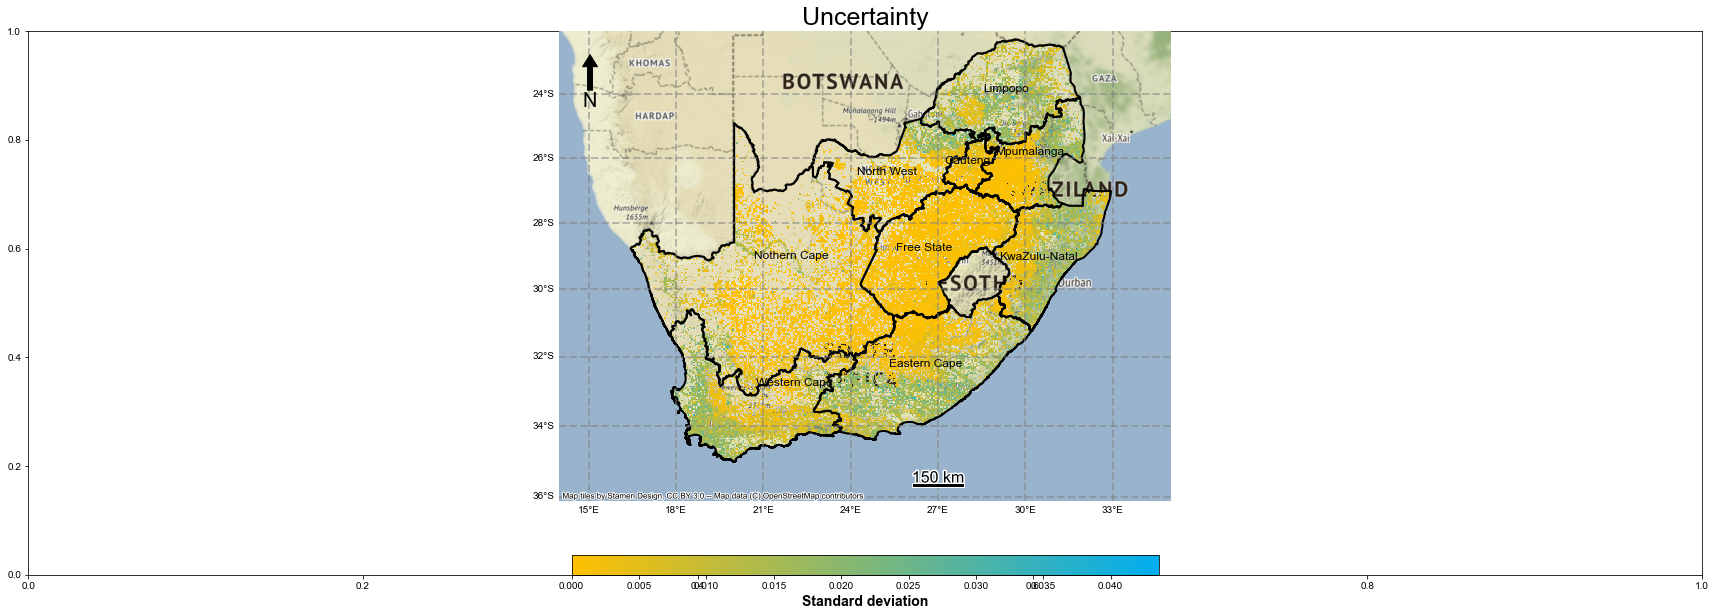

In [143]:
if __name__ == '__main__':
    
    #Set the Map Title
    title = 'Uncertainty'
    #Set the Colour bar title
    cb_label = 'Standard deviation'
    colors = ["#FFC000", "#00AEEF"]
    
#     cb_label = 'Mean SHAP value (logodds)'
#     colors = ["#1E88E5", "#ff0d57"]

    # set the value column that will be visualised
    variable = 'std'
    #uncomment if plotting shap vales
    # set the range for the choropleth values
    vmin, vmax = merge[variable].min(), merge[variable].max()
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, figsize=(30, 10))
    ax = plt.axes(projection=ccrs.Mercator())
    # remove the axis
    ax.axis('off')
    # add a title and annotation
    ax.set_title(title, fontdict={'fontsize': '25', 'fontweight' : '3'})
    # ax.annotate('Source: Wikipedia - https://en.wikipedia.org/wiki/Provinces_of_Indonesia', xy=(0.6, .05), xycoords='figure fraction', fontsize=12, color='#555555')
    
    cmap = LinearSegmentedColormap.from_list("mycmap", colors)
    # Create colorbar legend
    sm = plt.cm.ScalarMappable(cmap= cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    # empty array for the data range
    sm.set_array([]) # or alternatively sm._A = []. Not sure why this step is necessary, but many recommends it
    # add the colorbar to the figure
    fig.colorbar(sm, orientation = "horizontal", fraction=0.036, pad=0.1, aspect = 30)\
    .set_label(label= cb_label,size=14,weight='bold')
    
    #plot data
    #Add coastal boundaries/backdrop
    #ax.stock_img()
    #ax.coastlines(resolution='10m')
    # before plotting convert to common crs
    merge = merge.to_crs('EPSG:3857')
    # plot grid data
    merge.plot(column=variable, cmap= cmap, linewidth=0, ax=ax, edgecolor='0.8', alpha=1)
    provinces = gpd.read_file(r"D:\Miscellenous\Data\SA_boundaries\zaf_admbnda_adm1_sadb_ocha_20201109.shp")
    provinces= provinces.to_crs("EPSG:4326").to_crs("EPSG:3857")
    
    # add province name annotations
    provinces['label_position'] = provinces['geometry'].apply(lambda x: x.representative_point().coords[:])
    provinces['label_position'] = [coords[0] for coords in provinces['label_position']]
    for idx, row in provinces.iterrows():
        plt.annotate(text=row['ADM1_EN'], xy=row['label_position'], horizontalalignment='center', fontsize=12, alpha =1)
    provinces.geometry.boundary.plot(color=None,edgecolor='k',linewidth = 2,ax=ax)
    ax.set_extent([14, 35, -36, -22], ccrs.Geodetic())
    
    # add scale bar
    scale_bar(ax, ccrs.Mercator(), 150, location = (0.5, 00.05))  # 100 km scale bar
    # or to use m instead of km
    # scale_bar(ax, ccrs.Mercator(), 100000, m_per_unit=1, units='m')
    # or to use miles instead of km
    # scale_bar(ax, ccrs.Mercator(), 60, m_per_unit=1609.34, units='miles')
    
    # add basemap
    ctx.add_basemap(ax)
    
    # add gridlines and coords
    gl = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(),linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    plt.savefig(f"D:/phd/Chapter_2/nat_drivers/4results/figures2/{'map_uncertainty.png'}", dpi=600, transparent=True, bbox_inches='tight')
    plt.show()

In [ ]:
# upload FC to GEE-convert to raster